In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os, sys
import json
import pickle
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote
from scipy import sparse
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from itertools import combinations
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from functions import load_data
from functions import dict_gender_to_gendercategory
from functions import dict_gendercategory_to_gender
from functions import dict_age_to_agecategory
from functions import dict_agecategory_to_age
from functions import load_user_json
from functions import url2domain

from functions import get_time
from functions import get_mode
from functions import make_harmonic_features

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import seaborn as sns
import datetime
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
!

In [2]:
pd.read_csv('/data/share/project01/gender_age_dataset.txt', sep='\t').to_csv('gender_age_dataset.txt', sep='\t')

In [3]:
df_test, df_train = load_data()

In [4]:
# import json

# with open('titles-aiohttp.json') as json_file:  
#     data = json.load(json_file)
    
# data = pd.DataFrame([[x,data[x]['title']] for x in data],columns = ['url','title'])
# data['title'] = data['title'].astype(str)
# data['title'] = data['title'].str.lower()
# data['title'] = data['title'].map(lambda x: re.sub(r'\W', ' ', x)).map(lambda x: re.sub(r'\s+', ' ', x))
# data['title'] = data['title'].str.split()
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer("russian") 
# data['title'] = data['title'].map(lambda x: [stemmer.stem(prof) for prof in x])

In [17]:
def feature_engineering(df):
    #пол - перевод в категории 
    df['gender_cat'] = df['gender'].map(dict_gender_to_gendercategory)
    
    #возраст - перевод в категории 
    df['age_cat'] = df['age'].map(dict_age_to_agecategory)
    
    #user_json - конвертация строки в json
    df['user_json'] = load_user_json(df['user_json'])
    
    #user_json - вычитываем домен
    df['domain_list'] = df['user_json'].map(lambda x: [url2domain(visit['url']) for visit in x['visits']])
    
    #user_json - вычитываем unix время
    df['time_list'] = df['user_json'].map(lambda x: [visit['timestamp'] for visit in x['visits']])
    
    
    #получаем для юзера список времен посечения страницы (число от 0 до 24)
    df['hours'] = [list(map(get_time,time_list)) for time_list in df['time_list']]
    
    #получаем моду времени посещения страницы
    df['hour_mode'] = [get_mode(hour_list) for hour_list in df['hours']]
    
    #конвертация моды в косинус
    df['hours_harmonics_cos'] = [make_harmonic_features(time_list)[0] for time_list in df['hour_mode']]
    
    #конвертация моды в синус
    df['hours_harmonics_sin'] = [make_harmonic_features(time_list)[1] for time_list in df['hour_mode']]
    
    #количество визитов
    df['visits'] = df['time_list'].apply(len)
    
    #логарифмируем количество визитов
    df['visits'] = np.log1p(df['visits'])
    
    #время между первым и последним посещением
    df['time_range'] = df['time_list'].apply(np.ptp)
    
    #среднее время на посещение
    df['visit_rate'] = df['time_range']/df['visits']
    
    #логарифмируем среднее время на посещение
    df['visit_rate'] = np.log1p(df['visit_rate'])
    
    return df

df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

In [5]:

def identity_tokenizer(text):
    return text

def tfidf(train, test):
    '''должна быть колонка domain_list'''
    
    def convert_to_df(data, df):    
        cols = list(map(lambda x: 'tfidf_'+str(x),np.arange(data.shape[1]))) 
        data = data.todense()
        data = np.squeeze(np.asarray(data))
        data = pd.DataFrame(data, columns = cols, index = df.index, dtype = np.float16)
        
        return pd.concat([data,df],axis=1), cols
    
    #tfidf

    tfidf_model = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, max_features = 2000)
    tfidf_model.fit(train['domain_list'].append(test['domain_list']))
    
    train_data = tfidf_model.transform(train['domain_list'])
    test_data = tfidf_model.transform(test['domain_list'])
    
    # tsvd = TruncatedSVD(n_components=200)
    # svd_data = tsvd.fit_transform(sparse_tfidf_domain_list)
    
    train_data, cols = convert_to_df(train_data, train)
    test_data, _ = convert_to_df(test_data, test)
    
    
    return train_data, test_data, tfidf_model, cols

In [6]:
df_train, df_test, tfidf_model, cols = tfidf(df_train, df_test)

In [7]:
with open('../models/tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf_model, f)

In [8]:
set(df_train.columns)- set(cols)

{'age',
 'age_cat',
 'domain_list',
 'gender',
 'gender_cat',
 'hour_mode',
 'hours',
 'hours_harmonics_cos',
 'hours_harmonics_sin',
 'time_list',
 'time_range',
 'uid',
 'user_json',
 'visit_rate',
 'visits'}

# Gender

## cv

In [9]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'binary',
#     'metric': 'auc',
#     'num_leaves': 31,
#     'learning_rate': 0.01,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

In [13]:
# df_features = pd.read_pickle('../data/df_features.pkl',compression='bz2')
# cols_topics = list(map(lambda x: 'topic_'+str(x),np.arange(30)))
# df_train = pd.merge(df_train,df_features[cols_topics+['uid']],how='left',on='uid')
# df_test = pd.merge(df_test,df_features[cols_topics+['uid']],how='left',on='uid')

In [17]:
# #находим количество деревьев
# SPLITS = 10
# col_target = 'gender_cat'
# cols_features = cols+cols_topics+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

# lgb_train = lgb.Dataset(df_train[cols_features], df_train[col_target])
# res = lgb.cv(params,lgb_train,num_boost_round=2000,nfold=SPLITS,stratified=True,shuffle=True, 
#              early_stopping_rounds=100)

# num_boost = np.argmax(res['auc-mean'])
# num_boost, res['auc-mean'][num_boost], res['auc-stdv'][num_boost]

(1554, 0.7557194642096233, 0.0048152081961714485)

In [19]:
# #находим количество деревьев
# SPLITS = 10
# col_target = 'gender_cat'
# cols_features = cols+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

# lgb_train = lgb.Dataset(df_train[cols_features], df_train[col_target])
# res = lgb.cv(params,lgb_train,num_boost_round=2000,nfold=SPLITS,stratified=True,shuffle=True, 
#              early_stopping_rounds=100)

# num_boost = np.argmax(res['auc-mean'])
# num_boost, res['auc-mean'][num_boost], res['auc-stdv'][num_boost]

(1502, 0.756443181788651, 0.004821593367667096)

In [24]:
# #получаем out of fold (oof) предсказания
# num_boost = 1600

# SPLITS = 10
# col_target = 'gender_cat'
# cols_features = cols+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

# kf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=0)
# kf.get_n_splits(df_train)
# scores = {}

# for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(len(df_train)), df_train[col_target])):
    
# #     X_test = df_train.loc[df_train.index[test_index]].copy()
# #     X_train = df_train.loc[df_train.index[train_index]].copy()
    
    
#     lda = LatentDirichletAllocation(n_components=30, random_state=0)
#     lda.fit(df_train.loc[df_train.index[train_index], cols]) 
    
#     data = lda.transform(df_train.loc[df_train.index[train_index], cols])
#     data = pd.DataFrame(data,index = df_train.index[train_index], columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
#     train = pd.concat([
#         df_train.loc[df_train.index[train_index], cols_features],
#         data
#     ],axis=1)
    
#     data = lda.transform(df_train.loc[df_train.index[test_index], cols])
#     data = pd.DataFrame(data,index = df_train.index[test_index], columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
#     test = pd.concat([
#         df_train.loc[df_train.index[test_index], cols_features],
#         data
#     ],axis=1)
#     # Подготовка данных в нужном формате 
#     print('Current Fold: {}\n'.format(fold+1))
#     dtrain = lgb.Dataset(data=train,
#                          label=df_train.loc[df_train.index[train_index], col_target])
#     dvalid = lgb.Dataset(data=test,
#                          label=df_train.loc[df_train.index[test_index], col_target])

#     # Обучение 
#     evals_result = {}
#     model = lgb.train(params=params, 
#                       train_set=dtrain, 
#                       valid_sets=[dtrain, dvalid],
#                       valid_names=['train', 'eval'],
#                       num_boost_round=num_boost, 
#                       evals_result=evals_result,
# #                       categorical_feature=cols_cat, 
#                       verbose_eval=False)

#     # Построение прогнозов на TARGET: 0/1
#     df_train.loc[df_train.index[test_index], 'PREDICT'] = model.predict(df_train.loc[df_train.index[test_index], cols_features])

#     # Построение прогнозов при разном виде взаимодействия
#     scores[fold] = evals_result['eval']['auc']
    

Current Fold: 1

Current Fold: 2

Current Fold: 3

Current Fold: 4

Current Fold: 5

Current Fold: 6

Current Fold: 7

Current Fold: 8

Current Fold: 9

Current Fold: 10



In [25]:
# scores = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in scores.items()]))
# score_max = scores.mean(axis=1).max()
# num_boost = np.argmax(scores.mean(axis=1))
# std = scores.std(axis=1)[num_boost]
# print(num_boost, score_max, std)

1555 0.7573363819152685 0.004825916343797984


/opt/anaconda/envs/bd9/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


## analiz

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


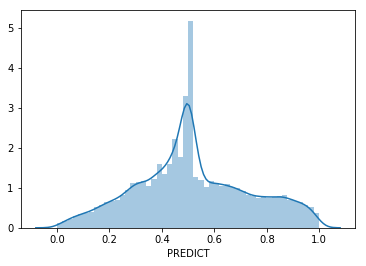

In [15]:
# sns.distplot(df_train['PREDICT'])

In [16]:
# df_train['class']= np.nan
# df_train.loc[df_train['PREDICT']<=0.5174055011345399, 'class']=0
# df_train.loc[df_train['PREDICT']>0.5174055011345399, 'class']=1
# mask = df_train['class'].isnull()
    
# [sum(mask)/len(df_train), accuracy_score(df_train.loc[~mask,col_target],df_train.loc[~mask,'class'])]

[0.0, 0.6807792351541314]

In [17]:
# acc_score = []
# step = 0.01
# for a,b in tqdm(combinations(np.arange(step,1,step), 2)):
# #     a = 0.2
# #     b = 0.8
#     df_train['class']= np.nan
#     df_train.loc[df_train['PREDICT']<a,'class']=0
#     df_train.loc[df_train['PREDICT']>b,'class']=1
#     mask = df_train['class'].isnull()
    
#     acc_score.append([a,b, sum(mask)/len(df_train), accuracy_score(df_train.loc[~mask,col_target],df_train.loc[~mask,'class'])])

4851it [00:50, 96.65it/s] 


In [18]:
# acc_score = pd.DataFrame(acc_score,columns=['a','b','perc_nulls', 'acc_score'])

In [19]:
# mask = acc_score['perc_nulls']<0.5

# acc_score[mask].sort_values('acc_score',ascending=False)

,a,b,perc_nulls,acc_score
2733,0.34,0.62,0.499972,0.792529
2861,0.36,0.63,0.490232,0.790902
2924,0.37,0.64,0.488904,0.790417
2797,0.35,0.62,0.489457,0.790244
2987,0.38,0.66,0.496845,0.790134
2732,0.34,0.61,0.489125,0.788864
2923,0.37,0.63,0.478720,0.788513
2986,0.38,0.65,0.486386,0.788373
3049,0.39,0.68,0.498118,0.788002
2860,0.36,0.62,0.479246,0.787874


## train

In [26]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_boost = 1555

In [31]:
col_target = 'gender_cat'
cols_features = cols+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

lda = LatentDirichletAllocation(n_components=30, random_state=0)
lda.fit(df_train[cols]) 

data = lda.transform(df_train[cols])
data = pd.DataFrame(data,index = df_train.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
train = pd.concat([
    df_train[cols_features],
    data
],axis=1)

    
with open('../models/lda.pkl', 'wb') as f:
    pickle.dump(lda, f)
    
lgb_train = lgb.Dataset(train, df_train[col_target])
model_gender = lgb.train(params,lgb_train,num_boost_round=num_boost)
model_gender.save_model('../models/vb_lgb_model_gender.txt')

In [35]:

data = lda.transform(df_test[cols])
data = pd.DataFrame(data,index = df_test.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
test = pd.concat([
    df_test[cols_features],
    data
],axis=1)

In [36]:
# test.shape,df_test.shape

((5000, 2035), (5000, 2045))

In [37]:
# df = pd.DataFrame(index = test.index)
# df['predict']  = model_gender.predict(test[model_gender.feature_name()])

# # mask = (df['predict']<0.4) & (df['predict']>0.5)
# # df = df[mask]

# # df['predict'] = df['predict']>0.5174055011345399
# # df['gender'] = np.vectorize(dict_gendercategory_to_gender.__getitem__)(df['predict'])


/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


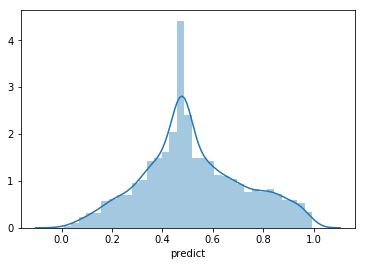

In [38]:
# sns.distplot(df['predict'])

# AGE

## cv

In [9]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'metric': 'multi_error',#['multiclass','multi_error'],
#     'num_class': 5,
#     'num_leaves': 31,
#     'learning_rate': 0.01,
#     'feature_fraction': 0.8,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

In [23]:
# #находим количество деревьев
# SPLITS = 10
# col_target = 'age_cat'
# cols_features = cols+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']

# lgb_train = lgb.Dataset(df_train[cols_features], df_train[col_target])
# res = lgb.cv(params,lgb_train,num_boost_round=2000,nfold=SPLITS,stratified=True,shuffle=True, 
#              early_stopping_rounds=100)

# num_boost = np.argmin(res['multi_error-mean'])
# num_boost, res['multi_error-mean'][num_boost], res['multi_error-stdv'][num_boost]

(532, 0.5441641034165959, 0.003189221830195312)

In [42]:
# #получаем out of fold(oof) предсказания
# for col in ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']:
#     df_train[col] = np.nan

# SPLITS = 10
# col_target = 'age_cat'
# cols_features = cols+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']
# num_boost = 1000

# kf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=0)
# kf.get_n_splits(df_train)
# scores = {}

# for fold, (train_index, test_index) in enumerate(kf.split(np.zeros(len(df_train)), df_train[col_target])):
    
# #     X_test = df_train.loc[df_train.index[test_index]].copy()
# #     X_train = df_train.loc[df_train.index[train_index]].copy()


    
#     lda = LatentDirichletAllocation(n_components=30, random_state=0)
#     lda.fit(df_train.loc[df_train.index[train_index], cols]) 
    
#     data = lda.transform(df_train.loc[df_train.index[train_index], cols])
#     data = pd.DataFrame(data,index = df_train.index[train_index], columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
#     train = pd.concat([
#         df_train.loc[df_train.index[train_index], cols_features],
#         data
#     ],axis=1)
    
#     data = lda.transform(df_train.loc[df_train.index[test_index], cols])
#     data = pd.DataFrame(data,index = df_train.index[test_index], columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
#     test = pd.concat([
#         df_train.loc[df_train.index[test_index], cols_features],
#         data
#     ],axis=1)
#     # Подготовка данных в нужном формате 
#     print('Current Fold: {}\n'.format(fold+1))
#     dtrain = lgb.Dataset(data=train,
#                          label=df_train.loc[df_train.index[train_index], col_target])
#     dvalid = lgb.Dataset(data=test,
#                          label=df_train.loc[df_train.index[test_index], col_target])


#     # Обучение 
#     evals_result = {}
#     model = lgb.train(params=params, 
#                       train_set=dtrain, 
#                       valid_sets=[dtrain, dvalid],
#                       valid_names=['train', 'eval'],
#                       num_boost_round=num_boost, 
#                       evals_result=evals_result,
# #                       categorical_feature=cols_cat, 
#                       verbose_eval=False)

#     # Построение прогнозов на TARGET: 0/1
#     df_train.loc[df_train.index[test_index], ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']] = model.predict(df_train.loc[df_train.index[test_index], cols_features])
#     # Построение прогнозов при разном виде взаимодействия
#     scores[fold] = evals_result['eval']['multi_error']
    

Current Fold: 1

Current Fold: 2

Current Fold: 3

Current Fold: 4

Current Fold: 5

Current Fold: 6

Current Fold: 7

Current Fold: 8

Current Fold: 9

Current Fold: 10



In [52]:
# scores = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in scores.items()]))
# score_max = scores.mean(axis=1).min()
# num_boost = np.argmin(scores.mean(axis=1))
# std = scores.std(axis=1)[num_boost]
# print(num_boost, score_max, std)

486 0.5461844858913383 0.003886131711312994


/opt/anaconda/envs/bd9/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [43]:
# df_train['PREDICT_AGE'] = np.argmax(df_train[['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']].values,axis=1)

## train

In [10]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_error',#['multiclass','multi_error'],
    'num_class': 5,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [13]:
col_target = 'age_cat'
cols_features = cols+['hours_harmonics_cos','hours_harmonics_sin','visit_rate','time_range','visits']
num_boost = 486

lda = LatentDirichletAllocation(n_components=30, random_state=0)
lda.fit(df_train[cols]) 

data = lda.transform(df_train[cols])
data = pd.DataFrame(data,index = df_train.index, columns=list(map(lambda x: 'lda_'+str(x),np.arange(data.shape[1])))) 
train = pd.concat([
    df_train[cols_features],
    data
],axis=1)

    
with open('../models/lda.pkl', 'wb') as f:
    pickle.dump(lda, f)
    
lgb_train = lgb.Dataset(train, df_train[col_target])
model_gender = lgb.train(params,lgb_train,num_boost_round=num_boost)
model_gender.save_model('../models/vb_lgb_model_age.txt')

In [14]:
lda.transform(df_train[cols])

array([[0.01666667, 0.01666667, 0.01666667, ..., 0.01666667, 0.01666667,
        0.01666667],
       [0.01304542, 0.43123596, 0.01304542, ..., 0.01304542, 0.01304542,
        0.01304542],
       [0.01262036, 0.01262036, 0.01262036, ..., 0.01262036, 0.01262036,
        0.01262036],
       ...,
       [0.01150639, 0.01150639, 0.25937863, ..., 0.01150639, 0.01150639,
        0.01150639],
       [0.01666667, 0.01666667, 0.01666667, ..., 0.01666667, 0.01666667,
        0.01666667],
       [0.01466222, 0.01466222, 0.01466222, ..., 0.01466225, 0.01466222,
        0.01466222]])

## analiz

In [44]:
# df_train.groupby(['age_cat','PREDICT_AGE']).size().unstack('PREDICT_AGE')

PREDICT_AGE,0,1,2,3,4
age_cat,,,,,
0,84,4294,487,30,3
1,28,12771,2542,90,26
2,20,6240,2966,117,17
3,12,3047,1487,168,30
4,1,1039,497,97,45


In [45]:
# col_list = ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']
# col_num_list = np.arange(0,5,1)

# col = 'PREDICT_AGE1'
# col_num = 0

# df_train['gr'] = pd.cut(df_train[col], np.percentile(df_train[col],np.arange(0,100.00001,5)))
# df_train['true'] = (df_train['age_cat']==col_num).astype(int)
# df_train['predict'] = (df_train['PREDICT_AGE']==col_num).astype(int)

# # fig = plt.figure()
# # ax1 = fig.add_subplot(111)

# # ax2 = ax1.twinx()

# # df_train.groupby('gr').apply(lambda x:  recall_score(x['true'],x['predict'])).to_frame().plot(ax = ax1)
# # df_train.groupby('gr')['true'].sum().plot.bar(ax = ax2)
# # for tick in ax1.get_xticklabels():
# #     tick.set_rotation(90)
# # plt.show()

In [46]:
df_train[col_list]

,PREDICT_AGE1,PREDICT_AGE2,PREDICT_AGE3,PREDICT_AGE4,PREDICT_AGE5
0,0.104628,0.405203,0.313508,0.129493,0.047168
1,0.106662,0.422860,0.302647,0.118064,0.049767
2,0.112860,0.392762,0.314527,0.132660,0.047191
3,0.098029,0.420504,0.301050,0.130340,0.050077
4,0.057691,0.259295,0.311807,0.244059,0.127148
5,0.110214,0.426424,0.278025,0.133341,0.051995
6,0.084364,0.366284,0.377734,0.109453,0.062165
7,0.126884,0.389966,0.275216,0.167769,0.040164
8,0.076721,0.441523,0.307371,0.125212,0.049172
9,0.137536,0.419248,0.262169,0.136062,0.044986


In [47]:
# df_train.groupby('gr')[['true','predict']].agg(['count','sum'])

true      predict     
                 count  sum   count  sum
gr                                      
(0.0213, 0.0485]  1806   44    1806    0
(0.0485, 0.0567]  1807   72    1807    0
(0.0567, 0.0637]  1807   98    1807    0
(0.0637, 0.0706]  1807  118    1807    0
(0.0706, 0.0765]  1807  146    1807    0
(0.0765, 0.0814]  1807  162    1807    0
(0.0814, 0.0858]  1806  169    1806    0
(0.0858, 0.0895]  1807  213    1807    0
(0.0895, 0.0924]  1807  231    1807    0
(0.0924, 0.0955]  1807  241    1807    0
(0.0955, 0.0983]  1807  257    1807    0
(0.0983, 0.101]   1807  266    1807    0
(0.101, 0.103]    1807  291    1807    0
(0.103, 0.106]    1806  286    1806    0
(0.106, 0.109]    1807  309    1807    0
(0.109, 0.114]    1807  278    1807    0
(0.114, 0.122]    1807  343    1807    0
(0.122, 0.136]    1807  370    1807    0
(0.136, 0.159]    1807  414    1807    0
(0.159, 0.513]    1807  590    1807  145

In [48]:
# df_train[(df_train['PREDICT_AGE1']>0.203) & (df_train['PREDICT_AGE1']<=0.246)]

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,PREDICT,PREDICT_AGE1,PREDICT_AGE2,PREDICT_AGE3,PREDICT_AGE4,PREDICT_AGE5,PREDICT_AGE,gr,true,predict
67,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.132064,0.237462,0.340043,0.276026,0.104614,0.041855,1,"(0.159, 0.513]",0,0
92,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.442795,0.207464,0.383034,0.265213,0.094627,0.049661,1,"(0.159, 0.513]",0,0
159,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.635543,0.206427,0.518218,0.165483,0.075616,0.034256,1,"(0.159, 0.513]",0,0
347,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.649096,0.209097,0.427385,0.231739,0.093351,0.038429,1,"(0.159, 0.513]",0,0
484,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.038513,...,0.779183,0.232585,0.258625,0.305684,0.163185,0.039921,2,"(0.159, 0.513]",0,0
925,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.308211,0.205475,0.401103,0.255660,0.095922,0.041840,1,"(0.159, 0.513]",1,0
1163,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.270903,0.204162,0.299057,0.304489,0.141933,0.050360,2,"(0.159, 0.513]",1,0
1265,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.234025,0.216457,0.337374,0.262419,0.130504,0.053245,1,"(0.159, 0.513]",1,0
2340,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.240590,0.226635,0.390761,0.228166,0.113500,0.040937,1,"(0.159, 0.513]",0,0
2422,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.408816,0.216471,0.366681,0.244922,0.127341,0.044586,1,"(0.159, 0.513]",0,0


In [49]:
# df_train['age_error'] = df_train['PREDICT_AGE'] != df_train['age_cat']

In [51]:
# df_train['age_error'].mean()

0.5563119154352759

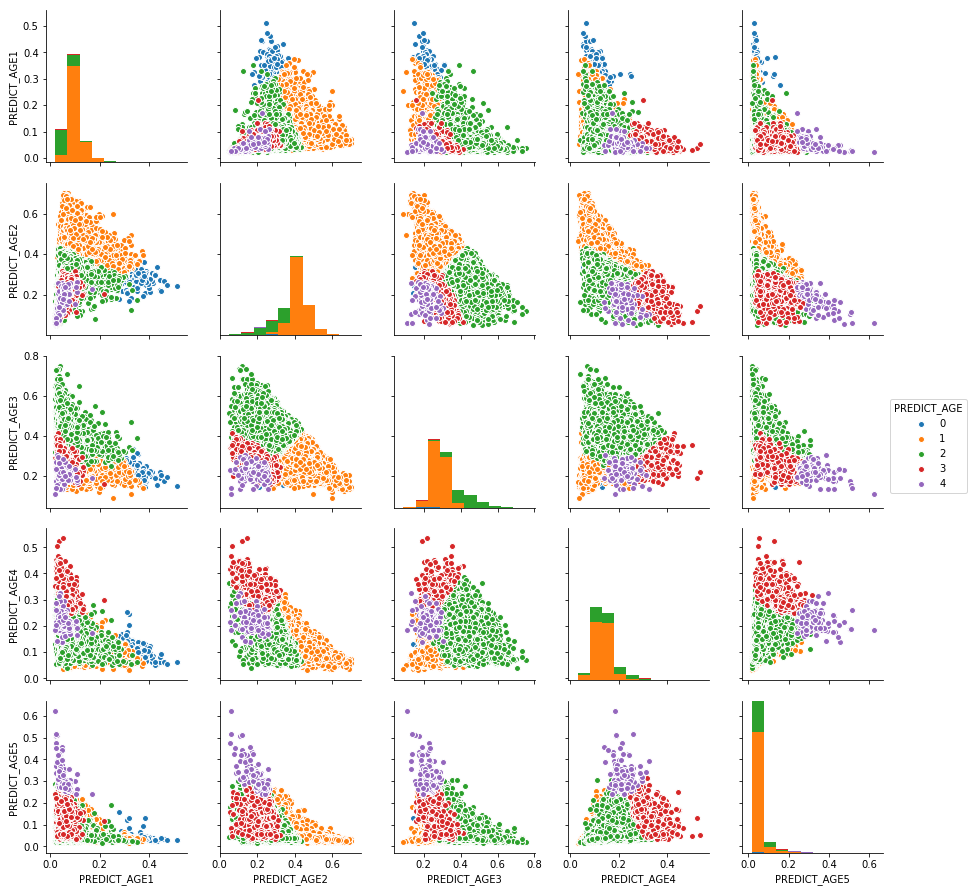

In [50]:
# sns.pairplot(df_train,vars = col_list, hue='PREDICT_AGE')

In [ ]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.set(style="dark")
# rs = np.random.RandomState(50)

# # Set up the matplotlib figure
# f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# # Rotate the starting point around the cubehelix hue circle
# for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

#     # Create a cubehelix colormap to use with kdeplot
#     cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

#     # Generate and plot a random bivariate dataset
#     x, y = rs.randn(2, 50)
#     sns.kdeplot(x, y, cmap=cmap, shade=True, cut=5, ax=ax)
#     ax.set(xlim=(-3, 3), ylim=(-3, 3))

# f.tight_layout()

In [80]:
# from sklearn.tree import DecisionTreeClassifier

In [97]:
# dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=3200)

In [98]:
# dt.fit(df_train[col_list],df_train['age_error'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [96]:
# df_train.shape

(36138, 2027)

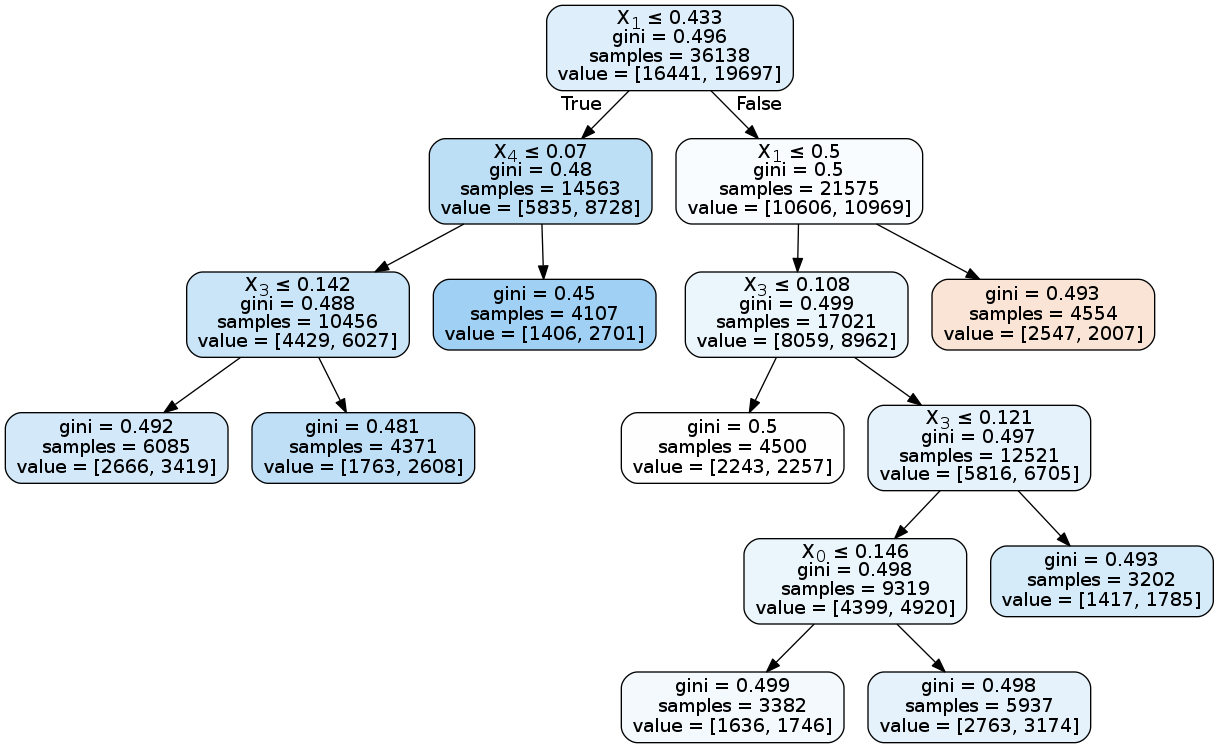

In [99]:
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

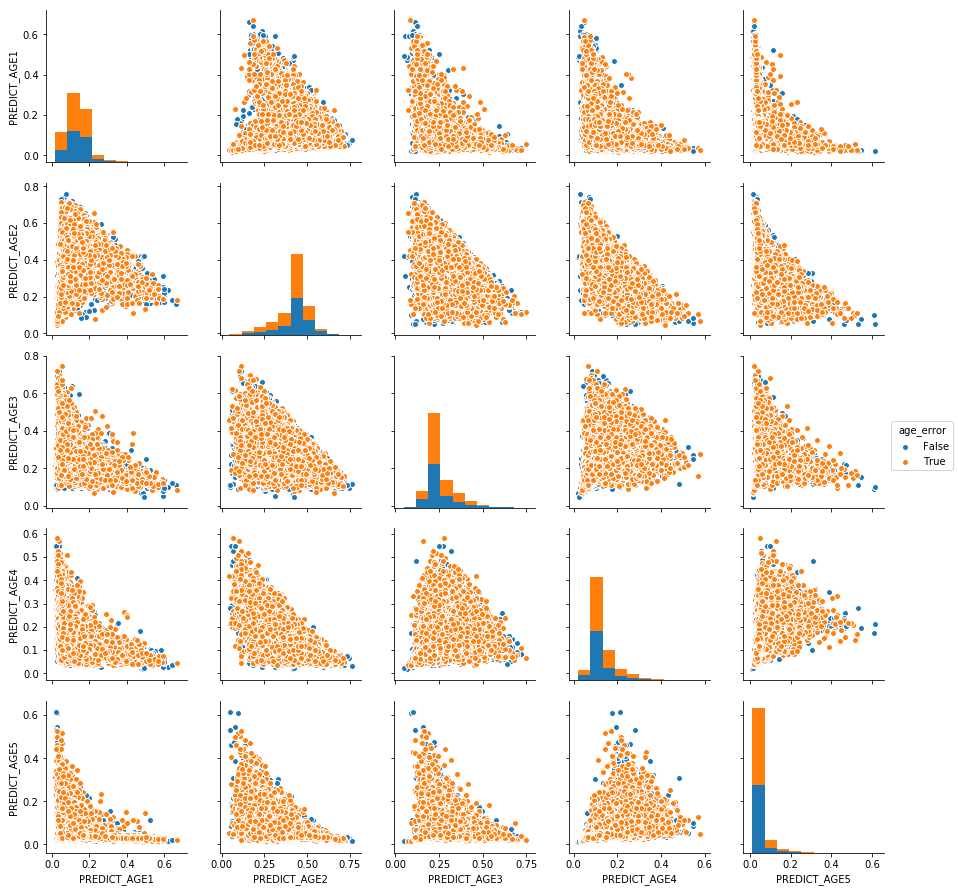

In [100]:
# sns.pairplot(df_train,vars = col_list, hue='age_error')

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


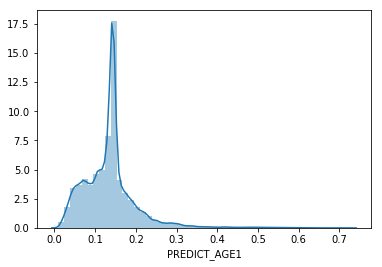

In [16]:
# sns.distplot(df_train['PREDICT_AGE1'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


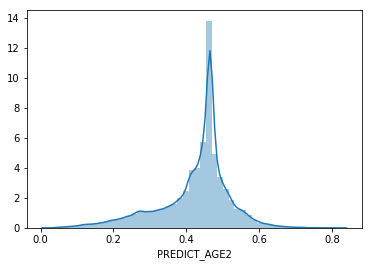

In [17]:
# sns.distplot(df_train['PREDICT_AGE2'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


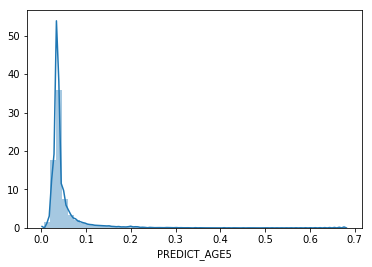

In [13]:
# sns.distplot(df_train['PREDICT_AGE5'])

In [58]:
# df_train['PREDICT_AGE'].value_counts()

1    30478
2     4009
3      945
0      507
4      199
Name: PREDICT_AGE, dtype: int64

In [49]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import recall_score

0.039309112567004166


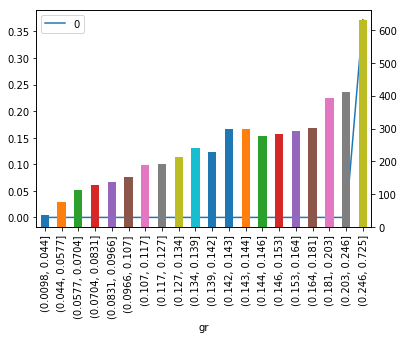

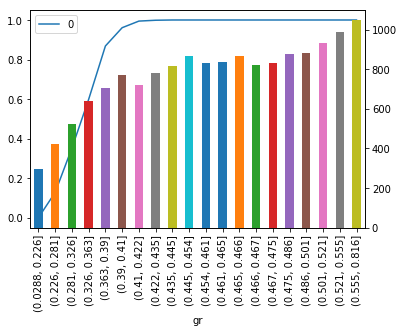

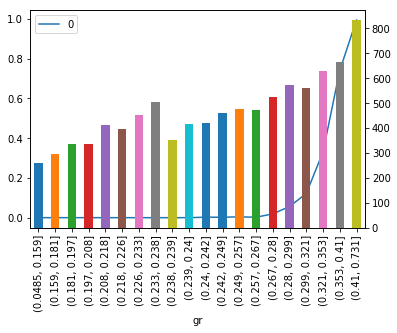

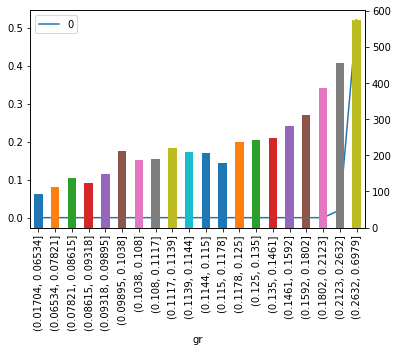

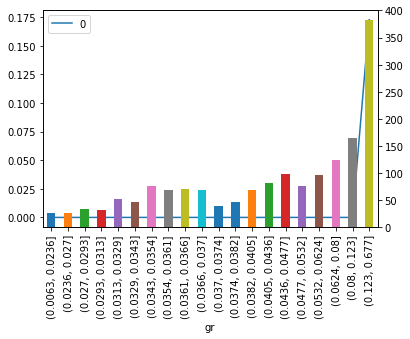

In [57]:
# col_list = ['PREDICT_AGE1', 'PREDICT_AGE2', 'PREDICT_AGE3', 'PREDICT_AGE4', 'PREDICT_AGE5']
# col_num_list = np.arange(0,5,1)

# for col, col_num in zip(col_list, col_num_list):
#     df_train['gr'] = pd.cut(df_train[col], np.percentile(df_train[col],np.arange(0,100.00001,5)))
#     df_train['true'] = (df_train['age_cat']==col_num).astype(int)
#     df_train['predict'] = (df_train['PREDICT_AGE']==col_num).astype(int)

#     fig = plt.figure()
#     ax1 = fig.add_subplot(111)

#     ax2 = ax1.twinx()
    
#     df_train.groupby('gr').apply(lambda x:  recall_score(x['true'],x['predict'])).to_frame().plot(ax = ax1)
#     df_train.groupby('gr')['true'].sum().plot.bar(ax = ax2)
#     for tick in ax1.get_xticklabels():
#         tick.set_rotation(90)
#     plt.show()

In [63]:
# acc_score = []
# step = 0.05
# for a,b in tqdm(combinations(np.arange(step,1,step), 2)):
# #     a = 0.2
# #     b = 0.8
#     df_train['class']= np.nan
#     df_train.loc[df_train['PREDICT']<a,'class']=0
#     df_train.loc[df_train['PREDICT']>b,'class']=1
#     mask = df_train['class'].isnull()
#     acc = (df_train[~mask][['gender_cat','age_cat']].values==df_train[~mask][['class','PREDICT_AGE']].values).sum(axis=1)==2
#     acc = sum(acc)/len(acc)
#     acc_score.append([a,b, sum(mask)/len(df_train), acc])


0it [00:00, ?it/s]
1it [00:00,  1.76it/s]
2it [00:01,  1.99it/s]
3it [00:01,  1.89it/s]
4it [00:02,  1.87it/s]
5it [00:02,  2.01it/s]
6it [00:02,  2.16it/s]
7it [00:03,  2.30it/s]
8it [00:03,  2.44it/s]
9it [00:03,  2.57it/s]
10it [00:03,  2.73it/s]
11it [00:03,  2.91it/s]
12it [00:03,  3.08it/s]
14it [00:04,  3.41it/s]
16it [00:04,  3.74it/s]
19it [00:04,  3.94it/s]
20it [00:05,  3.82it/s]
21it [00:05,  3.72it/s]
22it [00:05,  3.68it/s]
23it [00:06,  3.67it/s]
24it [00:06,  3.67it/s]
25it [00:06,  3.66it/s]
26it [00:07,  3.64it/s]
27it [00:07,  3.70it/s]
28it [00:07,  3.77it/s]
29it [00:07,  3.85it/s]
30it [00:07,  3.93it/s]
32it [00:07,  4.10it/s]
34it [00:07,  4.28it/s]
36it [00:08,  4.27it/s]
37it [00:08,  4.15it/s]
38it [00:09,  4.03it/s]
39it [00:09,  3.91it/s]
40it [00:10,  3.78it/s]
41it [00:11,  3.72it/s]
42it [00:11,  3.70it/s]
43it [00:11,  3.70it/s]
44it [00:11,  3.72it/s]
45it [00:12,  3.74it/s]
46it [00:12,  3.77it/s]
47it [00:12,  3.81it/s]
48it [00:12,  3.85it/s]
49it 

In [64]:
# acc_score = pd.DataFrame(acc_score,columns=['a','b','perc_nulls', 'acc_score'])
# mask = acc_score['perc_nulls']<0.5
# acc_score[mask].sort_values('acc_score',ascending=False)

,a,b,perc_nulls,acc_score
97,0.35,0.60,0.475455,0.362102
84,0.30,0.55,0.476673,0.360459
96,0.35,0.55,0.419614,0.354105
109,0.40,0.65,0.459212,0.354040
108,0.40,0.60,0.405252,0.350440
107,0.40,0.55,0.349411,0.344307
56,0.20,0.50,0.437351,0.340088
41,0.15,0.50,0.465410,0.339924
119,0.45,0.65,0.374481,0.339438
25,0.10,0.50,0.484282,0.339432


In [60]:
# acc_score

,a,b,perc_nulls,acc_score
0,0.01,0.02,0.001190,0.0
1,0.01,0.03,0.002739,0.0
2,0.01,0.04,0.004760,0.0
3,0.01,0.05,0.006835,0.0
4,0.01,0.06,0.008772,0.0
5,0.01,0.07,0.011760,0.0
6,0.01,0.08,0.014445,0.0
7,0.01,0.09,0.017821,0.0
8,0.01,0.10,0.021584,0.0
9,0.01,0.11,0.024711,0.0


# EDA

In [12]:
# df_train['gender'].value_counts(),18698/(17440+18698)

(M    18698
 F    17440
 Name: gender, dtype: int64, 0.5174055011345399)

In [7]:
# df_train['gender_cat'].value_counts()

1    18698
0    17440
Name: gender_cat, dtype: int64

In [8]:
# df_train['age'].value_counts()

25-34    15457
35-44     9360
18-24     4898
45-54     4744
>=55      1679
Name: age, dtype: int64

In [9]:
# df_train['age_cat'].value_counts()

1    15457
2     9360
0     4898
3     4744
4     1679
Name: age_cat, dtype: int64

In [10]:
# df_train.groupby(['gender','age']).size()

gender  age  
F       18-24    2886
        25-34    6791
        35-44    4271
        45-54    2597
        >=55      895
M       18-24    2012
        25-34    8666
        35-44    5089
        45-54    2147
        >=55      784
dtype: int64

In [11]:
# # пример json
# df_train.iloc[0].user_json

'{"visits": [{"url": "http://zebra-zoya.ru/200028-chehol-organayzer-dlja-macbook-11-grid-it.html?utm_campaign=397720794&utm_content=397729344&utm_medium=cpc&utm_source=begun", "timestamp": 1419688144068}, {"url": "http://news.yandex.ru/yandsearch?cl4url=chezasite.com/htc/htc-one-m9-delay-86327.html&lr=213&rpt=story", "timestamp": 1426666298001}, {"url": "http://www.sotovik.ru/news/240283-htc-one-m9-zaderzhivaetsja.html", "timestamp": 1426666298000}, {"url": "http://news.yandex.ru/yandsearch?cl4url=chezasite.com/htc/htc-one-m9-delay-86327.html&lr=213&rpt=story", "timestamp": 1426661722001}, {"url": "http://www.sotovik.ru/news/240283-htc-one-m9-zaderzhivaetsja.html", "timestamp": 1426661722000}]}'

In [14]:
# # самые частотные домены

# count_dom = Counter([dom for dom_list in df_train['domain_list'] for dom in dom_list])
# count_dom.most_common(1000)

[("b'avito.ru'", 466510),
 ("b'smotri.com'", 207694),
 ("b'24open.ru'", 91862),
 ("b'loveplanet.ru'", 91054),
 ("b'mail.rambler.ru'", 81633),
 ("b'youtube.com'", 80193),
 ("b'yandex.ru'", 76108),
 ("b'vk.com'", 75496),
 ("b'ebay.com'", 54400),
 ("b'yaplakal.com'", 50340),
 ("b'echo.msk.ru'", 49442),
 ("b'yabadu.ru'", 45692),
 ("b'topface.com'", 40251),
 ("b'b.kavanga.ru'", 38911),
 ("b'vz.ru'", 37858),
 ("b'ozon.ru'", 37565),
 ("b'svyaznoy.ru'", 36920),
 ("b'seasonvar.ru'", 35643),
 ("b'forum.littleone.ru'", 34780),
 ("b'go.youlamedia.com'", 33724),
 ("b'adme.ru'", 32109),
 ("b'content.adspynet.com'", 29965),
 ("b'mail.qip.ru'", 29110),
 ("b'999.md'", 28888),
 ("b'go.mail.ru'", 27858),
 ("b'flirchi.com'", 27032),
 ("b'sports.ru'", 25906),
 ("b'pass.rzd.ru'", 25234),
 ("b'news.sportbox.ru'", 24861),
 ("b'xvideos.com'", 24266),
 ("b'flirchi.ru'", 24067),
 ("b'trial-sport.ru'", 23621),
 ("b'google.ru'", 21758),
 ("b'irr.ru'", 21074),
 ("b'nnm.me'", 19912),
 ("b'banki.ru'", 19484),
 ("b'ru

## time

In [16]:
# datetime.datetime.utcfromtimestamp(1419688144.068)

datetime.datetime(2014, 12, 27, 13, 49, 4, 68000)

In [17]:
# datetime.datetime.utcfromtimestamp(1419688144068/1000)

datetime.datetime(2014, 12, 27, 13, 49, 4, 68000)

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


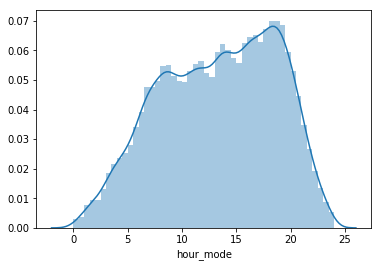

In [81]:
# sns.distplot(df_train['hour_mode'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


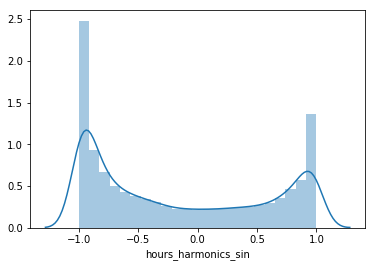

In [82]:
# sns.distplot(df_train['hours_harmonics_sin'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


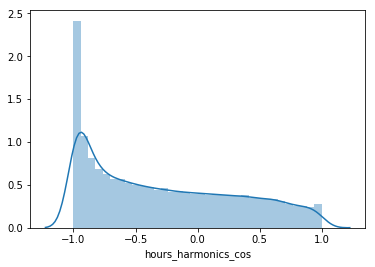

In [83]:
# sns.distplot(df_train['hours_harmonics_cos'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


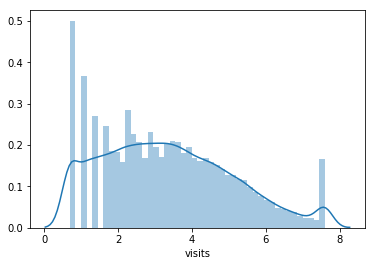

In [84]:
# sns.distplot(df_train['visits'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


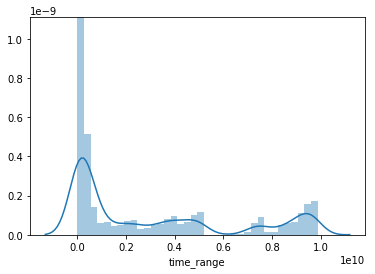

In [85]:
# sns.distplot(df_train['time_range'])

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


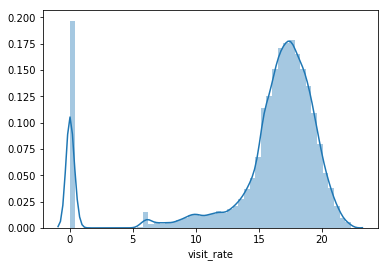

In [86]:
# sns.distplot(df_train['visit_rate'])

In [74]:
# features = ['visits','time_range','visit_rate','hours_harmonics_cos','hours_harmonics_sin','hour_mode']

In [75]:
# iter_gender = [0,1]

/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/anaconda/envs/bd9/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


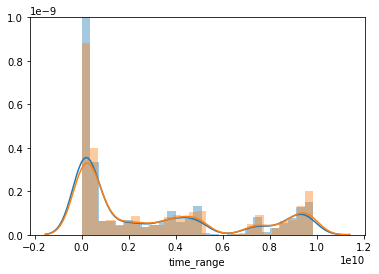

In [87]:
# [sns.distplot(df_train[df_train['gender_cat']==gen]['time_range']) for gen in iter_gender] 

In [92]:
# df_train['ya'] = ["b'yandex.ru'" in dom for dom in df_train['domain_list']]

In [105]:
# df_train[df_train['ya']==True]

,gender,age,uid,user_json,gender_cat,age_cat,domain_list,time_list,hours,hours_harmonics,hour_mode,hours_harmonics_cos,hours_harmonics_sin,visits,time_range,visit_rate,ya
6,F,25-34,d50bcef8-16ff-4e80-a9d5-9343698f4e7c,{'visits': [{'url': 'http://www.msn.com/ru-ru?...,0,1,"[b'msn.com', b'msn.com', b'msn.com', b'msn.com...","[1426704753001, 1426704753000, 1426695703001, ...","[18.875833333333333, 18.875833333333333, 16.36...","[0.1354273698319632, -0.9907872766141058]",18.518889,0.135427,-0.990787,3.465736,2731629001,18.294177,True
17,F,18-24,d51dd42c-3b36-4a6d-9747-0d5182e4e00f,{'visits': [{'url': 'http://www.ratanews.ru/ho...,0,0,"[b'ratanews.ru', b'ratanews.ru', b'ratanews.ru...","[1419887709188, 1419887507065, 1419887331498, ...","[21.2525, 21.19638888888889, 21.1475, 18.49833...","[-0.2944573406054019, 0.9556646245224285]",7.141667,-0.294457,0.955665,5.225747,9705665690,17.775620,True
21,M,25-34,d5241eeb-e364-4bac-9601-ac659d8fa865,{'visits': [{'url': 'http://www.xn----ctbbhcbd...,1,1,"[b'xn----ctbbhcbd9a8acccjsf5d6a9h.xn--p1ai', b...","[1427269874001, 1427269874000, 1427269868001, ...","[7.853888888888888, 7.853888888888888, 7.85222...","[-0.4540552943619585, 0.8909735067115493]",7.800278,-0.454055,0.890974,3.806662,522170001,16.289314,True
23,F,35-44,d5266ef8-c0a8-4ac6-a6bc-3e4a1cef6714,{'visits': [{'url': 'http://pinme.ru/u/kira/gl...,0,2,"[b'pinme.ru', b'om-22.ru', b'dogovor-urist.ru'...","[1418806338708, 1418806092290, 1427283648000, ...","[8.871666666666668, 8.803333333333335, 11.68, ...","[0.31053817943595574, 0.9505609076290704]",4.793889,0.310538,0.950561,4.406719,8477555710,18.466239,True
29,M,25-34,d52ab244-0a9c-434f-9dd0-34594b2a5993,{'visits': [{'url': 'http://hdays.ru/pozdravle...,1,1,"[b'hdays.ru', b'hdays.ru', b'hdays.ru', b'roma...","[1426822107000, 1426822106000, 1426822103000, ...","[3.4741666666666666, 3.473888888888889, 3.4730...","[-0.7564721145441241, 0.654025947434153]",9.276944,-0.756472,0.654026,3.044522,2657510000,18.704923,True
34,F,35-44,d530891e-d962-4ee4-85a6-f04098320339,"{'visits': [{'url': 'http://loveplanet.ru/', '...",0,2,"[b'loveplanet.ru', b'loveplanet.ru', b'calend....","[1427193071000, 1427180655000, 1427089800001, ...","[10.519722222222223, 7.070833333333333, 5.8333...","[-0.8344873956761043, 0.551027028790524]",9.770833,-0.834487,0.551027,2.197225,437707000,17.817619,True
38,M,18-24,d5338608-8281-4bfe-9c97-17294e5c1496,{'visits': [{'url': 'http://www.xrest.net/vide...,1,0,"[b'xrest.net', b'xrest.net', b'autocentre.ua',...","[1419813925995, 1419813686955, 1418939335734, ...","[0.7569444444444444, 0.6905555555555556, 21.81...","[-0.6118722183560573, -0.7909566286491551]",15.485000,-0.611872,-0.790957,5.493061,9610911871,17.497227,True
41,M,25-34,d53567a3-8208-4f9e-83fb-0d99866b7970,{'visits': [{'url': 'http://kinogo.net/2646-te...,1,1,"[b'kinogo.net', b'kinogo.net', b'kinogo.net', ...","[1413812069000, 1413812048000, 1413811011000, ...","[13.574722222222222, 13.568888888888889, 13.28...","[-0.5359495918300146, 0.8442499837235656]",8.160556,-0.535950,0.844250,4.465908,4233137000,17.711862,True
43,M,25-34,d5376e3b-1d2c-438a-b5ed-fb2927e9c433,{'visits': [{'url': 'http://www.znay.ru/osago/...,1,1,"[b'znay.ru', b'yandex.ru', b'znay.ru', b'znay....","[1426998907001, 1426998907000, 1426998872001, ...","[4.585277777777778, 4.585277777777778, 4.57555...","[0.17393463927934172, 0.9847571991403593]",5.332222,0.173935,0.984757,3.465736,256565001,15.928906,True
45,M,45-54,d5388230-94da-4958-b8a9-8972a6764d43,{'visits': [{'url': 'https://www.avito.ru/mosk...,1,3,"[b'avito.ru', b'avito.ru', b'avito.ru', b'avit...","[1427164286000, 1427163984000, 1427163888000, ...","[2.5238888888888886, 2.4400000000000004, 2.413...","[0.1554288100158409, -0.9878470959703529]",18.596111,0.155429,-0.987847,7.601402,1373154000,13.439475,True


# стата

In [4]:
import psutil

In [5]:
psutil.virtual_memory()

svmem(total=270372945920, available=82627702784, percent=69.4, used=184074670080, free=68581220352, active=171133755392, inactive=26496618496, buffers=646164480, cached=17070891008, shared=2762665984, slab=1525612544)

In [6]:
270372945920/1024/1024/1024

251.80442810058594

In [7]:
import multiprocessing

multiprocessing.cpu_count()

56